<a href="https://colab.research.google.com/github/Dushyanttara/colab_research/blob/master/Group2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install pandas-profiling==2.6.0

In [0]:
import numpy as np
import pandas as pd
import pandas_profiling 
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy import sparse
from collections import *
import itertools
import random 
import os

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

In [0]:
from google.colab import files

#install kaggle library
!pip install -q kaggle

In [23]:
#upload kaggle api key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [28]:
#Get this from kaggle competition data tab
!kaggle competitions download -c talkingdata-adtracking-fraud-detection -p /content/dataset

 95% 156M/165M [00:01<00:00, 75.5MB/s]
100% 165M/165M [00:01<00:00, 92.5MB/s]
 98% 494M/504M [00:05<00:00, 80.9MB/s]
100% 504M/504M [00:06<00:00, 87.4MB/s]
 99% 1.24G/1.24G [00:14<00:00, 76.3MB/s]
100% 1.24G/1.24G [00:14<00:00, 91.5MB/s]
 83% 33.0M/39.8M [00:00<00:00, 48.7MB/s]
100% 39.8M/39.8M [00:00<00:00, 89.7MB/s]
  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 160MB/s]


In [10]:
#!unzip 'talkingdata-adtracking-fraud-detection.zip' dataset/

Archive:  talkingdata-adtracking-fraud-detection.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of talkingdata-adtracking-fraud-detection.zip or
        talkingdata-adtracking-fraud-detection.zip.zip, and cannot find talkingdata-adtracking-fraud-detection.zip.ZIP, period.


In [30]:
### READ DATA ###

skip = 500000
train_dim = 200000 
val_dim = 50000
drop_dim = 50000
test = 50000


df_train = pd.read_csv('dataset/train.csv.zip', 
                       skiprows=range(1,skip), nrows=train_dim)
df_train['click_time'] = pd.to_datetime(df_train['click_time'])
df_train.sort_values('click_time', inplace=True)
df_train.reset_index(drop=True, inplace=True)

df_val = pd.read_csv('dataset/train.csv.zip', 
                     skiprows=range(1,skip+train_dim), nrows=val_dim)
df_val['click_time'] = pd.to_datetime(df_val['click_time'])
df_val.sort_values('click_time', inplace=True)
df_val.reset_index(drop=True, inplace=True)

df_test = pd.read_csv('dataset/train.csv.zip', 
                      skiprows=range(1,skip+train_dim+val_dim+drop_dim), nrows=test)
df_test['click_time'] = pd.to_datetime(df_test['click_time'])
df_test.sort_values('click_time', inplace=True)
df_test.reset_index(drop=True, inplace=True)


print(df_train.shape, df_val.shape, df_test.shape)
df_train.head()

(200000, 8) (50000, 8) (50000, 8)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,49407,9,1,20,134,2017-11-06 16:09:59,NaN,0
1,202214,2,1,6,236,2017-11-06 16:09:59,NaN,0
2,88018,3,1,10,379,2017-11-06 16:09:59,NaN,0
3,65804,12,1,17,328,2017-11-06 16:09:59,NaN,0
4,19248,14,1,19,463,2017-11-06 16:09:59,NaN,0


In [0]:

### SELECT FEATURES AND IMPOSE STR TYPE ###

features = ['ip','app','device','os','channel']

df_train[features] = df_train[features].astype(str)
df_val[features] = df_val[features].astype(str)
df_test[features] = df_test[features].astype(str)

In [0]:

### MAP CATEGORICAL FEATURES INTO NUMBER ###

for feat in features:
    
    lbe = LabelEncoder()
    lbe.fit(df_train[feat].values)
    diz_map_train = dict(zip(lbe.classes_, lbe.transform(lbe.classes_)+1))
        
    for i in set(df_val[feat]).difference(df_train[feat]): ## if not in train impose 0
        diz_map_train[i] = 0
    
    for i in set(df_test[feat]).difference(df_train[feat]): ## if not in train impose 0
        diz_map_train[i] = 0
    
    df_train[feat] = [diz_map_train[i] for i in df_train[feat].values]
    df_val[feat] = [diz_map_train[i] for i in df_val[feat].values]
    df_test[feat] = [diz_map_train[i] for i in df_test[feat].values]

In [57]:
### CHECK UNKNOWN CLASSES IN VALIDATION/TEST ###

## unkwon in val
print([sum(df_val[f]==0)/len(df_val) for f in features])

## unkwon in test
print([sum(df_test[f]==0)/len(df_test) for f in features])

[0.13218, 0.00026, 0.00048, 0.0001, 4e-05]
[0.17026, 0.00022, 0.00046, 0.00016, 2e-05]


In [58]:

### HOW MANY CLASS IN EACH CATEGORICAL ###

df_train[features].max()

ip         21842
app          150
device       114
os           115
channel      145
dtype: int64

In [61]:
### PLOT TRAIN LABEL DISTRIBUTION ###

df_train.plot(y='is_attributed', x='click_time', figsize=(16,6))

## Group count + Truncated SVD

In [62]:
diz_enc = {}

for g_f in features:
    
    passive_feat = features[:]
    passive_feat.remove(g_f)
    
    diz_group = defaultdict(list)
    for f in passive_feat:
        
        print('--- groupby:', g_f, '###', f, '---')
        group = df_train[[g_f,f]].astype(str).groupby(g_f)[f]
        group = group.apply(lambda x: ' '.join(list(x)))
        group_index = ['0']+list(group.index)
        
        enc_count = CountVectorizer()
        group = enc_count.fit_transform(group)
        group = sparse.vstack((sparse.csr_matrix((1,group.shape[1]), dtype='int64'), group))
        
        LSA = TruncatedSVD(n_components=3, random_state=33)
        group_enc = LSA.fit_transform(group)
        
        for i,k in enumerate(group_index):
            diz_group[int(k)].extend(list(group_enc[i]))
    
    diz_enc[g_f] = diz_group

--- groupby: ip ### app ---
--- groupby: ip ### device ---
--- groupby: ip ### os ---
--- groupby: ip ### channel ---
--- groupby: app ### ip ---
--- groupby: app ### device ---
--- groupby: app ### os ---
--- groupby: app ### channel ---
--- groupby: device ### ip ---
--- groupby: device ### app ---
--- groupby: device ### os ---
--- groupby: device ### channel ---
--- groupby: os ### ip ---
--- groupby: os ### app ---
--- groupby: os ### device ---
--- groupby: os ### channel ---
--- groupby: channel ### ip ---
--- groupby: channel ### app ---
--- groupby: channel ### device ---
--- groupby: channel ### os ---


In [0]:

### MAP CLASSES TO VECTORS ###

train_feat = df_train.copy()
val_feat = df_val.copy()
test_feat = df_test.copy()

for f in features:
    train_feat[f] = train_feat[f].map(diz_enc[f])
    val_feat[f] = val_feat[f].map(diz_enc[f])
    test_feat[f] = test_feat[f].map(diz_enc[f])
    
train_feat = [list(itertools.chain(*raw[1:])) for raw in train_feat[features].itertuples()]
val_feat = [list(itertools.chain(*raw[1:])) for raw in val_feat[features].itertuples()]
test_feat = [list(itertools.chain(*raw[1:])) for raw in test_feat[features].itertuples()]

In [0]:
### GET LABELS ###

y_train = df_train.is_attributed.values
y_val = df_val.is_attributed.values
y_test = df_test.is_attributed.values

In [65]:
### TRAIN RANDOMFOREST AND TUNE ON VALIDATION ###

parameters = {'n_estimators':[50,100,200]}
rfc = RandomForestClassifier(random_state=33)
model = GridSearchCV(estimator=rfc, param_grid=parameters, scoring='roc_auc',
                     cv=PredefinedSplit([-1]*len(y_train)+[0]*len(y_val)))

model.fit(np.vstack([train_feat, val_feat]), np.hstack([y_train, y_val]))

print(model.best_params_)
print(model.best_score_)

{'n_estimators': 200}
0.8952150420420596


In [66]:
print(roc_auc_score(y_test, model.predict_proba(test_feat)[:,1]))
print(classification_report(y_test, model.predict(test_feat)))

0.908117817531067
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49919
           1       0.44      0.30      0.35        81

    accuracy                           1.00     50000
   macro avg       0.72      0.65      0.68     50000
weighted avg       1.00      1.00      1.00     50000



In [67]:
confusion_matrix(y_test, model.predict(test_feat))

array([[49888,    31],
       [   57,    24]])

In [0]:
### VISUAL REPRESENTATION ###

scaler = StandardScaler()
scaler.fit(train_feat)

tsne = TSNE(n_components=2, random_state=33, n_iter=300, perplexity=3)
T = tsne.fit_transform(scaler.transform(val_feat))

In [0]:
%matplotlib inline

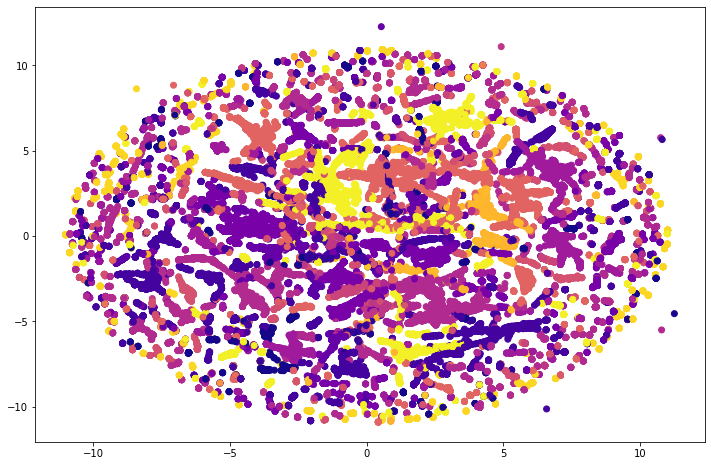

In [71]:

plt.figure(figsize=(12,8))
plt.scatter(T[:,0], T[:,1], c=df_val.app.astype(int), cmap='plasma')

## Group Count + Entropy

In [72]:
### CREATE ENCODING FOR EACH CATEGORICAL FEATURES ###

diz_enc = {}

for g_f in features:
    
    passive_feat = features[:]
    passive_feat.remove(g_f)
    
    diz_group = defaultdict(list)
    for f in passive_feat:
        
        print('--- groupby:', g_f, '###', f, '---')
        df = df_train.copy()
        df.reset_index(inplace=True)
        
        group = df.groupby([g_f, f])['index'].count()
        group = group.unstack().fillna(0)
        
        ent = group.apply(entropy, axis=1)
        for i,e in ent.to_dict().items():
            diz_group[i].extend([e])
        
        diz_group[0] = [.0]*len(passive_feat)
        
    diz_enc[g_f] = diz_group

--- groupby: ip ### app ---
--- groupby: ip ### device ---
--- groupby: ip ### os ---
--- groupby: ip ### channel ---
--- groupby: app ### ip ---
--- groupby: app ### device ---
--- groupby: app ### os ---
--- groupby: app ### channel ---
--- groupby: device ### ip ---
--- groupby: device ### app ---
--- groupby: device ### os ---
--- groupby: device ### channel ---
--- groupby: os ### ip ---
--- groupby: os ### app ---
--- groupby: os ### device ---
--- groupby: os ### channel ---
--- groupby: channel ### ip ---
--- groupby: channel ### app ---
--- groupby: channel ### device ---
--- groupby: channel ### os ---


In [0]:

train_feat = df_train.copy()
val_feat = df_val.copy()
test_feat = df_test.copy()

for f in features:
    train_feat[f] = train_feat[f].map(diz_enc[f])
    val_feat[f] = val_feat[f].map(diz_enc[f])
    test_feat[f] = test_feat[f].map(diz_enc[f])
    
train_feat = [list(itertools.chain(*raw[1:])) for raw in train_feat[features].itertuples()]
val_feat = [list(itertools.chain(*raw[1:])) for raw in val_feat[features].itertuples()]
test_feat = [list(itertools.chain(*raw[1:])) for raw in test_feat[features].itertuples()]

In [74]:
### TRAIN RANDOMFOREST AND TUNE ON VALIDATION ###

parameters = {'n_estimators':[50,100,200]}
rfc = RandomForestClassifier(random_state=33)
model = GridSearchCV(estimator=rfc, param_grid=parameters, scoring='roc_auc',
                     cv=PredefinedSplit([-1]*len(y_train)+[0]*len(y_val)))

model.fit(np.vstack([train_feat, val_feat]), np.hstack([y_train, y_val]))

print(model.best_params_)
print(model.best_score_)

{'n_estimators': 200}
0.8876865966260289


In [75]:
print(roc_auc_score(y_test, model.predict_proba(test_feat)[:,1]))
print(classification_report(y_test, model.predict(test_feat)))

0.8964460697935593
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49919
           1       0.45      0.26      0.33        81

    accuracy                           1.00     50000
   macro avg       0.72      0.63      0.66     50000
weighted avg       1.00      1.00      1.00     50000



In [76]:
confusion_matrix(y_test, model.predict(test_feat))

array([[49893,    26],
       [   60,    21]])

In [0]:
### VISUAL REPRESENTATION ###

scaler = StandardScaler()
scaler.fit(train_feat)

tsne = TSNE(n_components=2, random_state=33, n_iter=300, perplexity=3)
T = tsne.fit_transform(scaler.transform(val_feat))

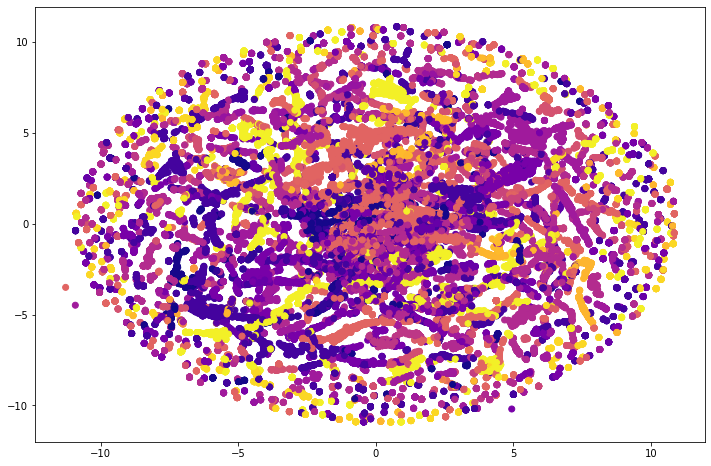

In [78]:
plt.figure(figsize=(12,8))
plt.scatter(T[:,0], T[:,1], c=df_val.app.astype(int), cmap='plasma')

## Group2Vec

In [0]:
### DEFINE GROUP2VEC MODEL ###

def get_embed(inp, size, emb_dim, name):

    emb = Embedding(size, emb_dim)(inp)
    emb = Flatten(name=name)(emb)
    
    return emb


def Group2Vec(df, group_key, emb_dim=8):
    
    opt = Adam(lr=0.0001, clipnorm=0.5)
                
    inps = []
    embs = {}
    for g_k in group_key:
        inp = Input((1,), name=g_k+'_inp')
        embs[g_k] = get_embed(inp, int(df[g_k].max())+1, emb_dim, g_k)
        inps.append(inp)
    
    outs = []
    for g_k in group_key:
        
        new_group_key = group_key[:]
        new_group_key.remove(g_k)
        
        dots = [Dot(axes=1)([embs[k], embs[g_k]]) for k in new_group_key]
        dot_product = Average()(dots)
        outs.append(dot_product)
        
    x = Concatenate()(outs)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inps, outputs=out)
    model.compile(optimizer=opt, loss='binary_crossentropy')
    
    return model

In [80]:
model = Group2Vec(df_train, group_key=features, emb_dim=16)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app_inp (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
ip_inp (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
device_inp (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
os_inp (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________________

In [81]:
### FIT GROUP2VEC ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)




model = Group2Vec(df_train, group_key=features, emb_dim=16)

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto')
history = model.fit([df_train[f].values for f in features], y_train, 
                     epochs=100, batch_size=512, verbose=2, callbacks=[es],
                     validation_data=([df_val[f].values for f in features], y_val))

Epoch 1/100
391/391 - 4s - loss: 0.6791 - val_loss: 0.6603
Epoch 2/100
391/391 - 4s - loss: 0.6257 - val_loss: 0.5851
Epoch 3/100
391/391 - 4s - loss: 0.5320 - val_loss: 0.4735
Epoch 4/100
391/391 - 4s - loss: 0.4231 - val_loss: 0.3542
Epoch 5/100
391/391 - 4s - loss: 0.3275 - val_loss: 0.2530
Epoch 6/100
391/391 - 4s - loss: 0.2566 - val_loss: 0.1774
Epoch 7/100
391/391 - 4s - loss: 0.2058 - val_loss: 0.1240
Epoch 8/100
391/391 - 4s - loss: 0.1699 - val_loss: 0.0872
Epoch 9/100
391/391 - 4s - loss: 0.1430 - val_loss: 0.0619
Epoch 10/100
391/391 - 4s - loss: 0.1229 - val_loss: 0.0444
Epoch 11/100
391/391 - 4s - loss: 0.1076 - val_loss: 0.0324
Epoch 12/100
391/391 - 4s - loss: 0.0950 - val_loss: 0.0240
Epoch 13/100
391/391 - 4s - loss: 0.0846 - val_loss: 0.0181
Epoch 14/100
391/391 - 4s - loss: 0.0765 - val_loss: 0.0141
Epoch 15/100
391/391 - 4s - loss: 0.0688 - val_loss: 0.0114
Epoch 16/100
391/391 - 4s - loss: 0.0637 - val_loss: 0.0096
Epoch 17/100
391/391 - 4s - loss: 0.0584 - val_lo

In [82]:
pred_val = model.predict([df_val[f].values for f in features])
print(pred_val.shape)

pred_test = model.predict([df_test[f].values for f in features])
print(pred_test.shape)

(50000, 1)
(50000, 1)


In [83]:
print(roc_auc_score(y_test, pred_test))
print(classification_report(y_test, (pred_test>0.5)+0))

0.9362966771602094
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49919
           1       1.00      0.09      0.16        81

    accuracy                           1.00     50000
   macro avg       1.00      0.54      0.58     50000
weighted avg       1.00      1.00      1.00     50000



In [84]:

confusion_matrix(y_test, (pred_test>0.5)+0)

array([[49919,     0],
       [   74,     7]])

In [0]:
### DEFINE EMBEDDING EXTRACTOR ###

emb_model = Model([model.get_layer(f+'_inp').input for f in features], 
                  [model.get_layer(f).output for f in features])

In [86]:
### EXTRACT EMBEDDINGS ###

emb_train = emb_model.predict([df_train[f].values for f in features])
emb_train = np.hstack(emb_train)
print(emb_train.shape)

emb_val = emb_model.predict([df_val[f].values for f in features])
emb_val = np.hstack(emb_val)
print(emb_val.shape)

emb_test = emb_model.predict([df_test[f].values for f in features])
emb_test = np.hstack(emb_test)
print(emb_test.shape)

(200000, 80)
(50000, 80)
(50000, 80)


In [0]:
### VISUAL REPRESENTATION ###

tsne = TSNE(n_components=2, random_state=33, n_iter=300, perplexity=3)
T = tsne.fit_transform(emb_val)

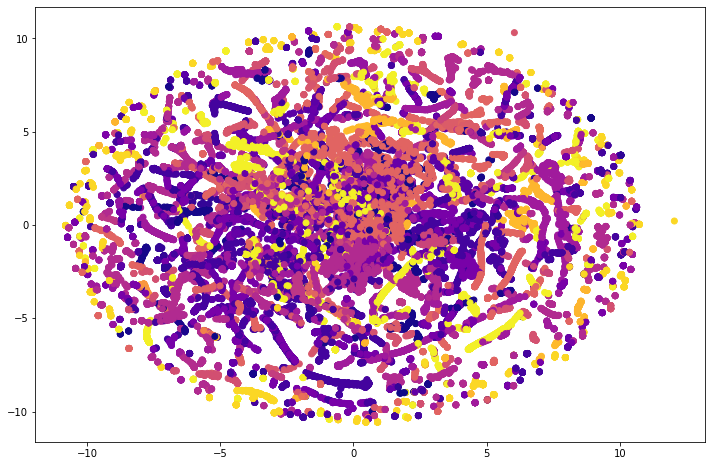

In [88]:

plt.figure(figsize=(12,8))
plt.scatter(T[:,0], T[:,1], c=df_val.app.astype(int), cmap='plasma')